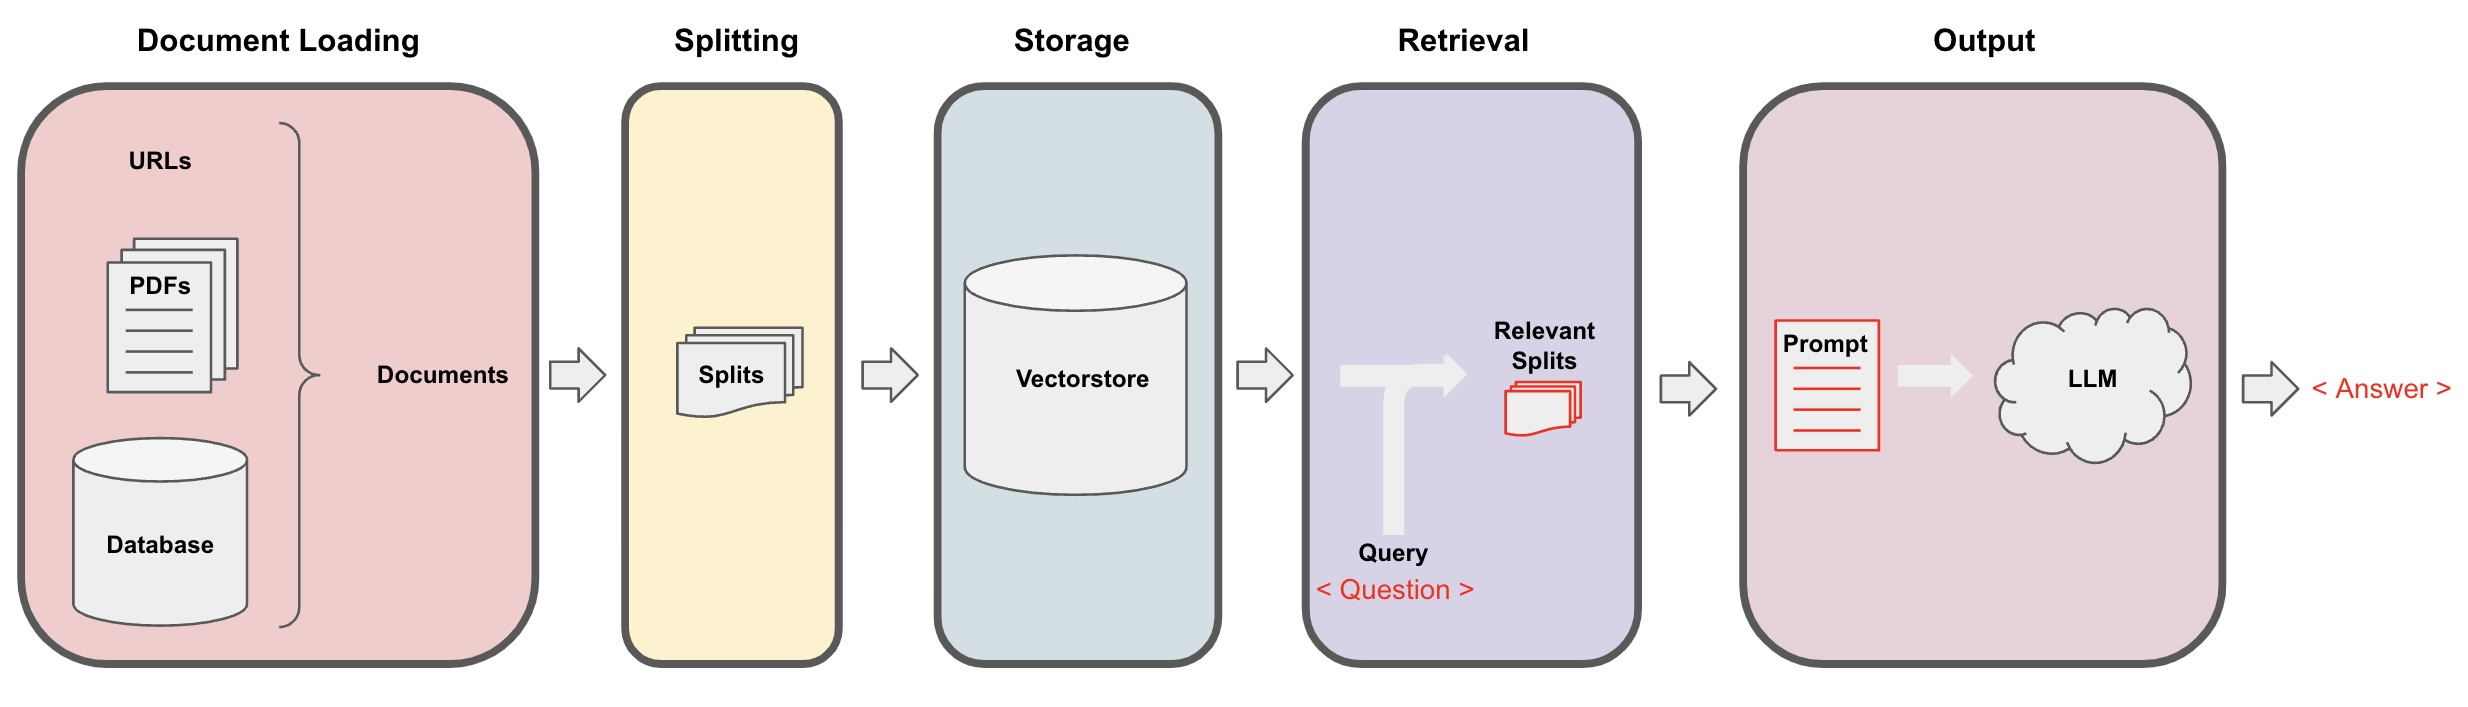

In [1]:
%load_ext dotenv
%dotenv
import os
api_token = os.getenv('TOKEN')

In [2]:
from torch import cuda, bfloat16
import transformers

model_id = 'meta-llama/Llama-2-70b-chat-hf'

device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

# set quantization configuration to load large model with less GPU memory
# this requires the `bitsandbytes` library
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=bfloat16
)

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map={'':0},
    use_auth_token=api_token
)
model.eval()
print(f"Model loaded on {device}")

/home/sourab/transformers/src/transformers/models/auto/auto_factory.py:460: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


[2023-07-31 22:52:17,352] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

/home/sourab/transformers/src/transformers/utils/hub.py:373: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Model loaded on cuda:0


In [3]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_id,
    use_auth_token=api_token
)

/home/sourab/transformers/src/transformers/models/auto/tokenization_auto.py:628: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [4]:

stop_list = ['\nHuman:', '\n```\n']

stop_token_ids = [tokenizer(x)['input_ids'] for x in stop_list]
stop_token_ids

[[1, 29871, 13, 29950, 7889, 29901], [1, 29871, 13, 28956, 13]]

In [5]:

import torch

stop_token_ids = [torch.LongTensor(x).to(device) for x in stop_token_ids]
stop_token_ids

[tensor([    1, 29871,    13, 29950,  7889, 29901], device='cuda:0'),
 tensor([    1, 29871,    13, 28956,    13], device='cuda:0')]

In [6]:
from transformers import StoppingCriteria, StoppingCriteriaList

# define custom stopping criteria object
class StopOnTokens(StoppingCriteria):
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        for stop_ids in stop_token_ids:
            if torch.eq(input_ids[0][-len(stop_ids):], stop_ids).all():
                return True
        return False

stopping_criteria = StoppingCriteriaList([StopOnTokens()])


In [7]:
llm = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    return_full_text=True,  # langchain expects the full text
    task='text-generation',
    # we pass model parameters here too
    stopping_criteria=stopping_criteria,  # without this model rambles during chat
    temperature=0.01,  # 'randomness' of outputs, 0.0 is the min and 1.0 the max
    top_p=0.95,
    top_k=50,
    max_new_tokens=512,  # mex number of tokens to generate in the output
    repetition_penalty=1.1  # without this output begins repeating
)

In [8]:
res = llm("Explain to me the difference between nuclear fission and fusion.")
print(res[0]["generated_text"])

Explain to me the difference between nuclear fission and fusion.
Nuclear fission is a process in which an atomic nucleus splits into two or more smaller nuclei, releasing a large amount of energy in the process. This occurs when an atom's nucleus is bombarded with a high-energy particle, such as a neutron. The resulting nuclei are typically smaller and lighter than the original nucleus, and the excess energy is released as radiation. Fission is the process used in nuclear power plants to generate electricity.
Nuclear fusion, on the other hand, is the process by which two or more atomic nuclei combine to form a single, heavier nucleus. This process also releases a large amount of energy, but it requires the nuclei to be brought together at extremely high temperatures and pressures, typically found in the core of stars. Fusion is the process that powers the sun and other stars.
The key difference between fission and fusion is the direction of the energy release. In fission, the energy is

In [10]:
from langchain.llms import HuggingFacePipeline

llm = HuggingFacePipeline(pipeline=llm)

In [11]:
llm(prompt="Explain to me the difference between nuclear fission and fusion.")

"\nNuclear fission is a process in which an atomic nucleus splits into two or more smaller nuclei, releasing a large amount of energy in the process. This occurs when an atom's nucleus is bombarded with a high-energy particle, such as a neutron. The resulting nuclei are typically smaller and lighter than the original nucleus, and the excess energy is released as radiation. Fission is the process used in nuclear power plants to generate electricity.\nNuclear fusion, on the other hand, is the process by which two or more atomic nuclei combine to form a single, heavier nucleus. This process also releases a large amount of energy, but it requires the nuclei to be brought together at extremely high temperatures and pressures, typically found in the core of stars. Fusion is the process that powers the sun and other stars.\nThe key difference between fission and fusion is the direction of the energy release. In fission, the energy is released outward from the nucleus, while in fusion, the ene

In [17]:
# loading
from langchain.document_loaders import DirectoryLoader, TextLoader

path = "/home/sourab/DHS-LLM-Workshop/6_Module/question_answering_gradio_app/doc_scraper/output"
loader = DirectoryLoader(
    path,
    glob="**/*.txt",
    loader_cls=TextLoader   
)

documents = loader.load()

In [19]:
documents[0]

Document(page_content='Semantic segmentation using LoRA\n\t\nThis guide demonstrates how to use LoRA, a low-rank approximation technique, to finetune a SegFormer model variant for semantic segmentation.\nBy using LoRA from 🤗 PEFT, we can reduce the number of trainable parameters in the SegFormer model to only 14% of the original trainable parameters.\nLoRA achieves this reduction by adding low-rank “update matrices” to specific blocks of the model, such as the attention\nblocks. During fine-tuning, only these matrices are trained, while the original model parameters are left unchanged.\nAt inference time, the update matrices are merged with the original model parameters to produce the final classification result.\nFor more information on LoRA, please refer to the original LoRA paper.\n\nInstall dependencies\n\t\nInstall the libraries required for model training:\n\n\n\tCopied\n!pip install transformers accelerate evaluate datasets peft -q\n\nAuthenticate to share your model\n\t\nTo sha

In [27]:
# chunking

from langchain.text_splitter import CharacterTextSplitter

text_splitter = CharacterTextSplitter(
    chunk_size=448,
    chunk_overlap=128,
    length_function=len,
    separator="\n"
)
chunks = text_splitter.split_documents(documents)


Created a chunk of size 494, which is longer than the specified 448
Created a chunk of size 732, which is longer than the specified 448
Created a chunk of size 491, which is longer than the specified 448
Created a chunk of size 468, which is longer than the specified 448
Created a chunk of size 732, which is longer than the specified 448
Created a chunk of size 491, which is longer than the specified 448
Created a chunk of size 468, which is longer than the specified 448
Created a chunk of size 533, which is longer than the specified 448
Created a chunk of size 533, which is longer than the specified 448
Created a chunk of size 483, which is longer than the specified 448
Created a chunk of size 468, which is longer than the specified 448
Created a chunk of size 524, which is longer than the specified 448
Created a chunk of size 543, which is longer than the specified 448
Created a chunk of size 543, which is longer than the specified 448
Created a chunk of size 483, which is longer tha

In [28]:
print(f"{len(documents)=} {len(chunks)=}")

len(documents)=42 len(chunks)=1134


In [34]:
chunks[0]

Document(page_content='Semantic segmentation using LoRA\n\t\nThis guide demonstrates how to use LoRA, a low-rank approximation technique, to finetune a SegFormer model variant for semantic segmentation.\nBy using LoRA from 🤗 PEFT, we can reduce the number of trainable parameters in the SegFormer model to only 14% of the original trainable parameters.\nLoRA achieves this reduction by adding low-rank “update matrices” to specific blocks of the model, such as the attention', metadata={'source': '/home/sourab/DHS-LLM-Workshop/6_Module/question_answering_gradio_app/doc_scraper/output/67f2c0a9b6ab4f4cb1294820fa4c0028.txt'})

In [ ]:
!pip install chromadb

In [51]:
# indexing
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores.chroma import Chroma

BI_ENCODER_MODEL = "intfloat/e5-large-v2"
PERSIST_DIR = "db"

hf_embedding_model = HuggingFaceEmbeddings(model_name=BI_ENCODER_MODEL)

vector_db = Chroma.from_documents(
    documents=chunks,
    embedding=hf_embedding_model,
    persist_directory=PERSIST_DIR
)
vector_db.persist()

In [52]:
print(vector_db._collection.count())

1134


In [53]:
k=10
fetch_k=20
vector_db.max_marginal_relevance_search("How do I create LoraConfig?", k=k, fetch_k=fetch_k)

[Document(page_content='Instantiate a base model.\nCreate a configuration (LoraConfig) where you define LoRA-specific parameters.\nWrap the base model with get_peft_model() to get a trainable PeftModel.\nTrain the PeftModel as you normally would train the base model.\nLoraConfig allows you to control how LoRA is applied to the base model through the following parameters:', metadata={'source': '/home/sourab/DHS-LLM-Workshop/6_Module/question_answering_gradio_app/doc_scraper/output/5b417ea7788f707968c7b3e47dee06e5.txt'}),
 Document(page_content='Instantiate a base model.\nCreate a configuration (LoraConfig) where you define LoRA-specific parameters.\nWrap the base model with get_peft_model() to get a trainable PeftModel.\nTrain the PeftModel as you normally would train the base model.\nLoraConfig allows you to control how LoRA is applied to the base model through the following parameters:', metadata={'source': '/home/sourab/DHS-LLM-Workshop/6_Module/question_answering_gradio_app/doc_scra

In [61]:
# Retrieval QA Chain
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

template = """Use the following pieces of context given in to answer the question at the end. \
If you don't know the answer, just say that you don't know, don't try to make up an answer. \
Keep the answer short and succinct.
        
Context:<{context}
Question:<{question}>
Helpful Answer:"""

QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vector_db.as_retriever(search_type="mmr"),
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT} 
)

result = qa_chain({"query": "How do I create LoraConfig?"})
print(result["result"])

<You create LoraConfig by defining the rank of the update matrices, target modules, and LoRA scaling factor. For example, LoraConfig(r=10, target_modules=['attention'], alpha=0.5) would create a LoraConfig instance with a rank of 10 for the update matrices, applying the LoRA update matrices to the attention modules, and a scaling factor of 0.5.>


In [58]:
# Memory

from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=False
)

In [63]:
from langchain.chains import RetrievalQA,  ConversationalRetrievalChain

retriever = vector_db.as_retriever(search_type="mmr", search_kwargs={"k": k})
qa = ConversationalRetrievalChain.from_llm(
    llm=llm, 
    chain_type="stuff", 
    retriever=retriever,
    get_chat_history=lambda h: h,
    memory=memory,
    verbose=True)

result = qa_chain({"query": "How do I create LoraConfig?"})
print(result["result"])

<You create LoraConfig by defining the rank of the update matrices, target modules, and LoRA scaling factor. For example, LoraConfig(r=10, target_modules=['attention'], alpha=0.5) would create a LoraConfig instance with a rank of 10 for the update matrices, applying the LoRA update matrices to the attention modules, and a scaling factor of 0.5.>


In [66]:
import gradio as gr
import random
import time

with gr.Blocks() as demo:
    chatbot = gr.Chatbot()
    msg = gr.Textbox()
    clear = gr.ClearButton([msg, chatbot])

    def respond(message, chat_history):
        bot_message = qa_chain({"query": message, "chat_history":chat_history})["result"]
        chat_history.append((message, bot_message.replace("<", "").replace(">","")))
        return "", chat_history

    msg.submit(respond, [msg, chatbot], [msg, chatbot])

demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://1aeaa1dfd84a5cc4a2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


/home/sourab/transformers/src/transformers/pipelines/base.py:1089: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


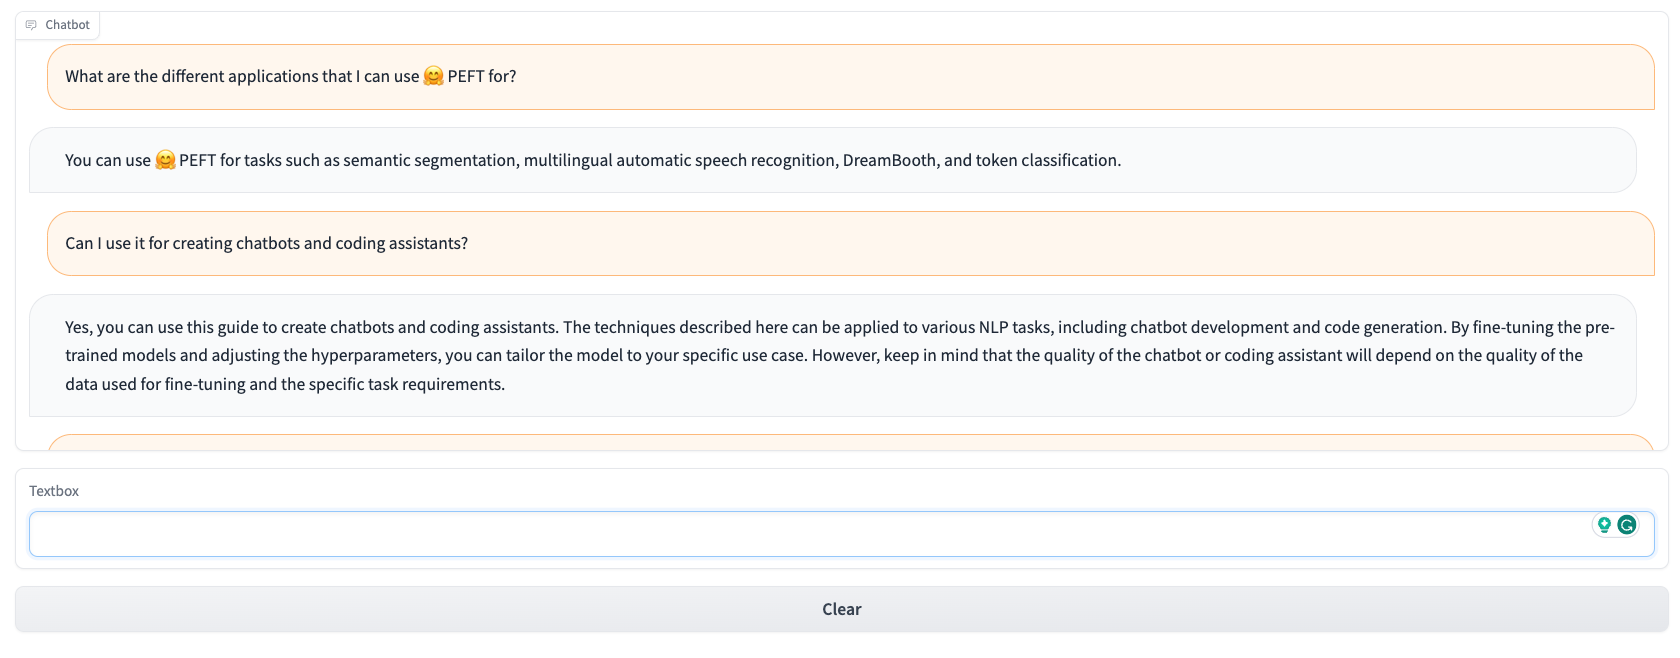

### References

1. [LangChain for LLM Application Developmen](https://www.deeplearning.ai/short-courses/langchain-for-llm-application-development/)
2. [LangChain: Chat with Your Data](https://www.deeplearning.ai/short-courses/langchain-chat-with-your-data/)
3. [How to create GPT-powered conversational bot for any website](https://youtu.be/T1hdz3eU3bg)
4. [LLaMa 70B Chatbot in Hugging Face and LangChain](https://github.com/pinecone-io/examples/blob/master/learn/generation/llm-field-guide/llama-2-70b-chat-agent.ipynb)
5. [Using HuggingFace, OpenAI, and Cohere models with Langchain](https://medium.com/the-techlife/using-huggingface-openai-and-cohere-models-with-langchain-db57af14ac5b)

### Further Readings
1. [Build a ChatGPT for PDFs with Langchain](https://www.analyticsvidhya.com/blog/2023/05/build-a-chatgpt-for-pdfs-with-langchain/)
2. [Build A ChatGPT For YouTube Videos with Langchain](https://www.analyticsvidhya.com/blog/2023/06/build-a-chatgpt-for-youtube-videos-with-langchain/)
3. [QA over Documents](https://python.langchain.com/docs/use_cases/question_answering/)